<a href="https://colab.research.google.com/github/sofianeHabach/ENSIAS-1A-Project/blob/master/Community_Detection_Analysis_and_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) Required Libraries

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import SpectralClustering
import itertools

# 2) Read Dataset

In [3]:
def read_facebook_dataset(file_path):
  G = nx.Graph()
  with open(file_path, 'r') as file:
    for line in file:
      if line.startswith('#')  or len(line.strip())==0:
        continue

      edge = line.strip().split()
      node1 = int(edge[0])
      node2 = int(edge[1])
      G.add_edge(node1, node2)
  return G

In [5]:
dataset_file = "/content/drive/MyDrive/UL/Project Dataset/facebook_combined.txt"
graph = read_facebook_dataset(dataset_file)

In [10]:
print("Plus grand degré :", max(dict(graph.degree()).values()))

Plus grand degré : 1045


# 3) Initial Graph Visualization

In [6]:
pos = nx.spring_layout(graph, seed=5)

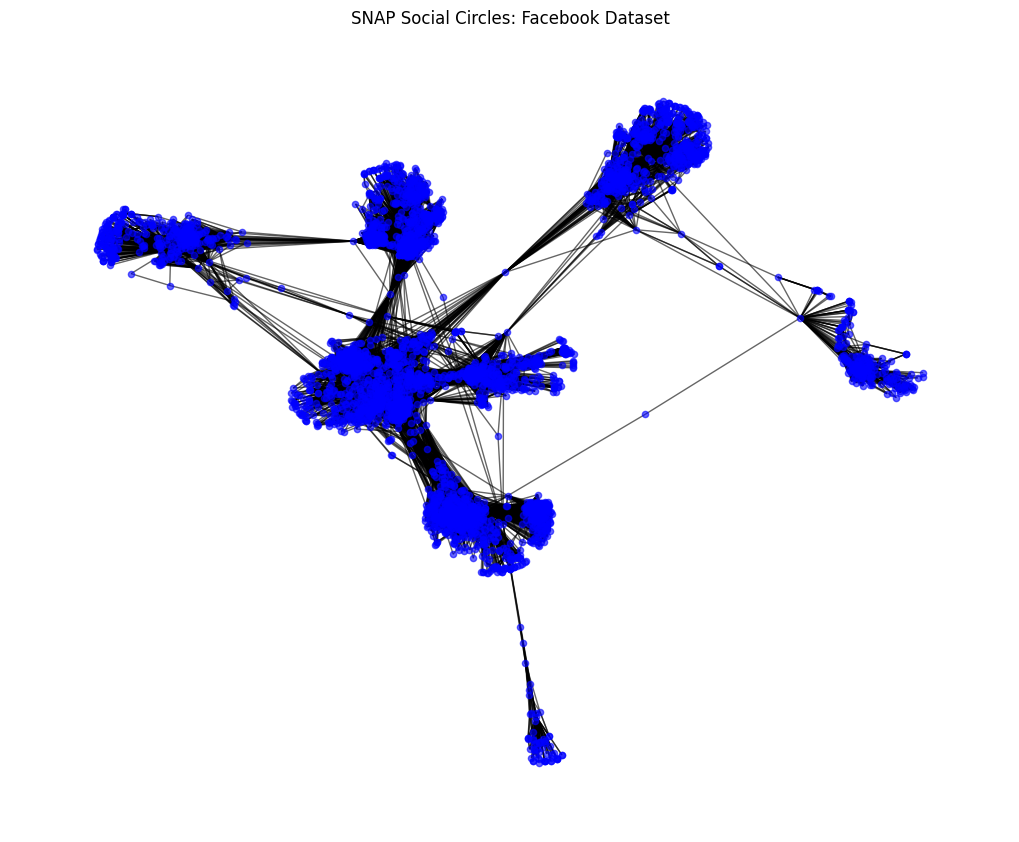

In [7]:
plt.figure(figsize=(10,8))
nx.draw(graph, pos, node_size=20, node_color="blue", alpha=0.6, with_labels=False)
plt.title("SNAP Social Circles: Facebook Dataset")
plt.show()

# 4) Degree Distribution

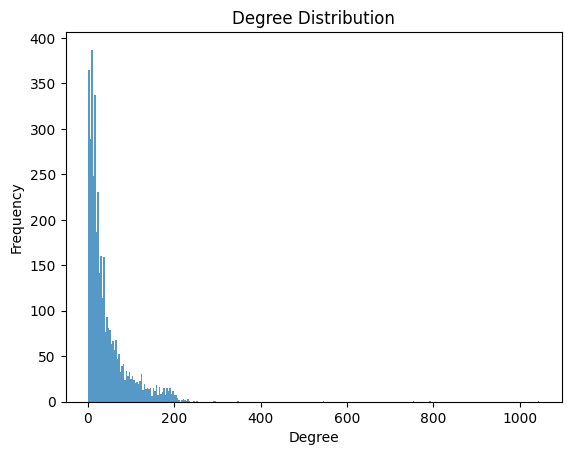

In [11]:
degree_sequence = sorted([d for n, d in graph.degree()], reverse=True)
plt.hist(degree_sequence, bins=300, alpha=0.75)
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()

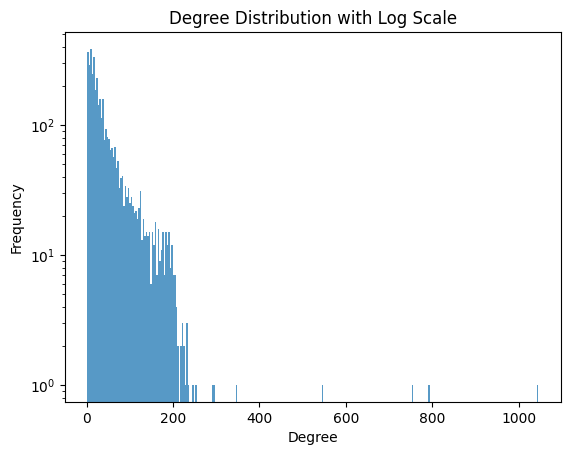

In [12]:
degree_sequence = sorted([d for n, d in graph.degree()], reverse=True)
plt.hist(degree_sequence, bins=300, alpha=0.75, log=True)
plt.title("Degree Distribution with Log Scale")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()

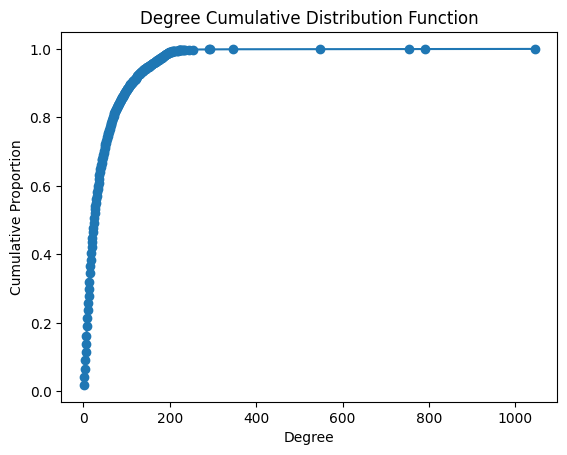

In [13]:
degree_sequence = sorted([d for n, d in graph.degree()], reverse=True)
unique_degrees, degree_counts = np.unique(degree_sequence, return_counts=True)
cumulative_degree_counts = np.cumsum(degree_counts)
cumulative_proportions = cumulative_degree_counts / len(degree_sequence)

# Plot the cumulative distribution function
plt.plot(unique_degrees, cumulative_proportions, marker='o', linestyle='-')
plt.title("Degree Cumulative Distribution Function")
plt.xlabel("Degree")
plt.ylabel("Cumulative Proportion")
#plt.xscale('log')  # Set x-axis to logarithmic scale for better visualization
plt.show()

# 5) Centrality Measures

In [14]:
degree_centrality = nx.degree_centrality(graph)
sorted_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
print("Top 10 users by Degree Centrality:")
for node, centrality in sorted_degree_centrality[:10]:
    print(f"User {node}: Degree Centrality = {centrality}")

Top 10 users by Degree Centrality:
User 107: Degree Centrality = 0.258791480931154
User 1684: Degree Centrality = 0.1961367013372957
User 1912: Degree Centrality = 0.18697374938088163
User 3437: Degree Centrality = 0.13546310054482416
User 0: Degree Centrality = 0.08593363051015354
User 2543: Degree Centrality = 0.07280832095096582
User 2347: Degree Centrality = 0.07206537890044576
User 1888: Degree Centrality = 0.0629024269440317
User 1800: Degree Centrality = 0.06067360079247152
User 1663: Degree Centrality = 0.058197127290737984


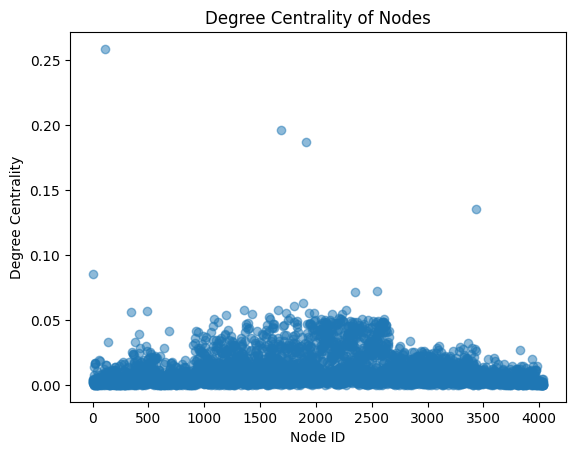

In [15]:
nodes = list(degree_centrality.keys())
centrality_values = list(degree_centrality.values())

# Plot a scatter plot of degree centrality
plt.scatter(nodes, centrality_values, alpha=0.5)
plt.title("Degree Centrality of Nodes")
plt.xlabel("Node ID")
plt.ylabel("Degree Centrality")
plt.show()

# 6) K-Means Clustering

In [16]:
# Conversion to adjacency matrix
adjmatrix = nx.adjacency_matrix(graph).todense()

In [17]:
adjmatrix

array([[0, 1, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [18]:
num_clusters = 15
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeanclusters = kmeans.fit_predict(adjmatrix)

In [19]:
# Convert cluster labels to community format
kmeancommunities = [[] for _ in range(num_clusters)]
for i, label in enumerate(kmeanclusters):
    kmeancommunities[label].append(i)

/usr/local/lib/python3.11/dist-packages/networkx/drawing/nx_pylab.py:457: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


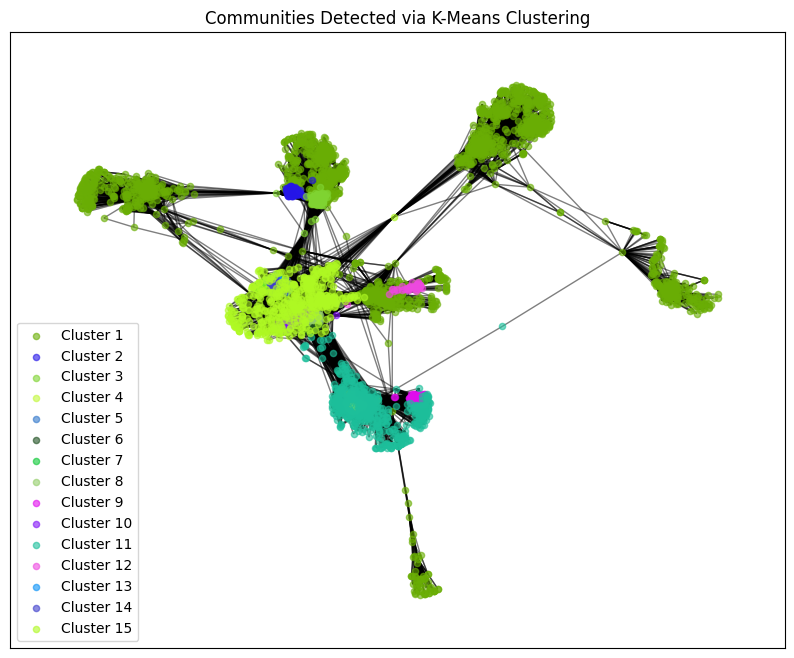

In [20]:
plt.figure(figsize=(10, 8))
for i in range(num_clusters):
    nodes_in_cluster = [node for node, cluster in zip(graph.nodes(), kmeanclusters) if cluster == i]
    nx.draw_networkx_nodes(graph, pos, nodelist=nodes_in_cluster, node_color=np.random.rand(3,),
                           node_size=20, alpha=0.6, label=f'Cluster {i + 1}')
nx.draw_networkx_edges(graph, pos, alpha=0.5)
plt.title('Communities Detected via K-Means Clustering')
plt.legend()
plt.show()

## 6.1) Metrics for K-Means

In [21]:
kmeans_modularity_score = nx.algorithms.community.modularity(graph, kmeancommunities)

In [22]:
# Calculate normalized cut ratio
cut_ratios = []
for i in range(num_clusters):
    cluster_nodes = np.where(kmeanclusters == i)[0]
    cut_size = nx.cut_size(graph, cluster_nodes)
    normalized_cut = cut_size / len(cluster_nodes)
    cut_ratios.append(normalized_cut)
kmeans_normalized_cut_ratio = np.mean(cut_ratios)

In [23]:
kmeans_silhouette = silhouette_score(adjmatrix, kmeanclusters, metric="euclidean")

In [24]:
def kmcompactness(adj_matrix, kmeanclusters, num_clusters):
    compactness = []
    for i in range(num_clusters):
        cluster_indices = np.where(kmeanclusters == i)[0]
        cluster_points = adjmatrix[cluster_indices, :]
        cluster_centroid = np.mean(cluster_points, axis=0)
        distances = np.linalg.norm(cluster_points - cluster_centroid, axis=1)
        compactness.append(np.mean(distances))
    return np.mean(compactness)

In [25]:
kmeans_compactness = kmcompactness(adjmatrix, kmeanclusters, num_clusters)

In [26]:
kmeans_chbscore = calinski_harabasz_score(adjmatrix, kmeanclusters)

In [27]:
def cluster_separability(adjmatrix, kmeanclusters, num_clusters):
    centroids = []
    for i in range(num_clusters):
        cluster_indices = np.where(kmeanclusters == i)[0]
        cluster_points = adjmatrix[cluster_indices, :]
        cluster_centroid = np.mean(cluster_points, axis=0)
        centroids.append(cluster_centroid)

    # Calculate separability
    separability_sum = 0
    num_combinations = 0
    for i in range(num_clusters):
        for j in range(i + 1, num_clusters):
            separability_sum += np.linalg.norm(centroids[i] - centroids[j])
            num_combinations += 1

    separability = separability_sum / num_combinations
    return separability

In [28]:
kmeans_separability = cluster_separability(adjmatrix, kmeanclusters, num_clusters)

In [29]:
print(f"K Means Modularity: {kmeans_modularity_score}")
print(f"K Means Normalized Cut Ratio: {kmeans_normalized_cut_ratio}")
print(f"K Means Silhouette Score: {kmeans_silhouette}")
print(f"K Means Total Compactness: {kmeans_compactness}")
print(f"K Means Calinski Harabasz Score : {kmeans_chbscore}")
print(f"K Means Separability: {kmeans_separability}")

K Means Modularity: 0.1329163366637281
K Means Normalized Cut Ratio: 40.381177862998086
K Means Silhouette Score: 0.05560531127457463
K Means Total Compactness: 5.697253348562146
K Means Calinski Harabasz Score : 176.51138483452095
K Means Separability: 8.293203201424161


# 7) Louvain Algorithm for Community Detection

In [30]:
louvain_communities = nx.algorithms.community.greedy_modularity_communities(graph)
print("Detected Communities:")
for i, community in enumerate(louvain_communities):
    print(f"Community {i + 1}: {community}")

Detected Communities:
Community 1: frozenset({1061, 1239, 1271, 3313, 1285, 1290, 3326, 1301, 3337, 3340, 3347, 3355, 1323, 3360, 1329, 3365, 1330, 3368, 3370, 2661, 2662, 2665, 2667, 2668, 2671, 2672, 2674, 2675, 2677, 2678, 1346, 2682, 2684, 2685, 2686, 2687, 2688, 2690, 2691, 2692, 2693, 2696, 2697, 2700, 2701, 2702, 3386, 2707, 2708, 2709, 2711, 2712, 2713, 2714, 2715, 2716, 2718, 2719, 2720, 2721, 2722, 2723, 2724, 2725, 2727, 2728, 2730, 2732, 2733, 2734, 2735, 2736, 2737, 2739, 2742, 2744, 2747, 2748, 2751, 2752, 2753, 2758, 2759, 2760, 2762, 2764, 2765, 2768, 2770, 2771, 2772, 2775, 2776, 2778, 2779, 2780, 2781, 3402, 2783, 2784, 2785, 3403, 2787, 2788, 2790, 2791, 2792, 2793, 2795, 2796, 2797, 3405, 2799, 2801, 2802, 2803, 2804, 2805, 2808, 2811, 2812, 2813, 2816, 2818, 2819, 2820, 2822, 2823, 2824, 2825, 2826, 2828, 2829, 2830, 2831, 2832, 2833, 2836, 2840, 2841, 2842, 2843, 2844, 2845, 2846, 2847, 2848, 2849, 2853, 2855, 2856, 2857, 2858, 2859, 2860, 2861, 2863, 2865, 2868, 

/usr/local/lib/python3.11/dist-packages/networkx/drawing/nx_pylab.py:457: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


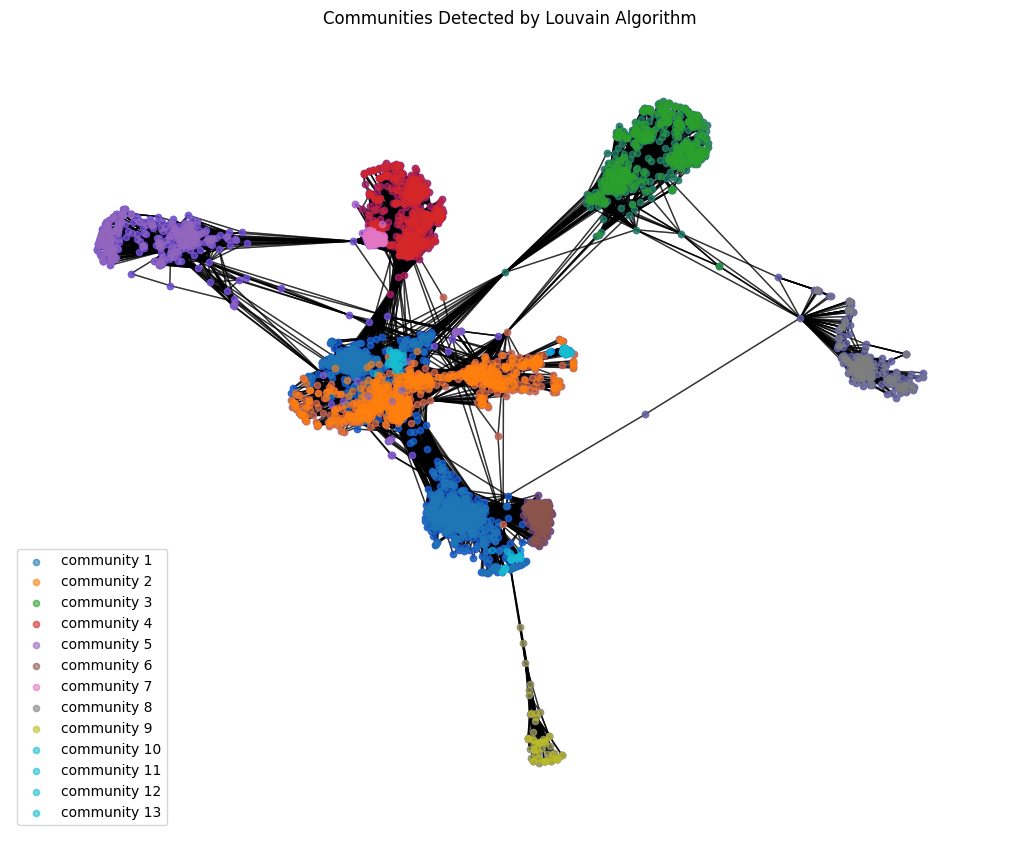

In [31]:
# Plot nodes without community information
plt.figure(figsize=(10, 8))
nx.draw(graph, pos, node_size=20, node_color="blue", alpha=0.6, with_labels=False)
plt.title("Communities Detected by Louvain Algorithm")

# Plot nodes with community information
for i, community in enumerate(louvain_communities):
  nx.draw_networkx_nodes(graph, pos, nodelist=community, node_color=plt.cm.tab10(i), node_size=20, alpha=0.6, label=f"community {i+1}")
nx.draw_networkx_edges(graph, pos, alpha=0.5)
plt.legend()
plt.show()

## 7.1) Metrics for Louvain Algorithm

In [32]:
louvain_communities = [list(community) for community in louvain_communities]

In [33]:
louvain_modularity_score = nx.algorithms.community.modularity(graph, louvain_communities)

In [34]:
# Calculate normalized cut ratio
cut_ratios = []
for community in louvain_communities:
    cut_size = nx.cut_size(graph, community)
    normalized_cut = cut_size / len(community)
    cut_ratios.append(normalized_cut)
louvain_normalized_cut_ratio = np.mean(cut_ratios)

In [35]:
cluster_labels = np.zeros(graph.number_of_nodes())
for i, community in enumerate(louvain_communities):
    cluster_labels[community] = i
louvain_silhouette = silhouette_score(nx.adjacency_matrix(graph).todense(), cluster_labels, metric='euclidean')

In [36]:
def calculate_community_compactness(adjmatrix, community):
    # Extract adjacency matrix for nodes in the community
    community_adjmatrix = adjmatrix[np.ix_(community, community)]
    # Calculate compactness as the average distance between nodes in the community
    compactness = np.mean(community_adjmatrix)
    return compactness

# Function to calculate sum of compactness for all communities
def total_compactness(communities, graph):
    # Convert graph to adjacency matrix
    adjmatrix = nx.adjacency_matrix(graph).todense()

    total_compactness = 0
    for community in communities:
        community_compactness = calculate_community_compactness(adjmatrix, community)
        total_compactness += community_compactness

    return total_compactness

In [37]:
louvain_compactness = total_compactness(louvain_communities, graph)
louvain_chbscore = calinski_harabasz_score(nx.adjacency_matrix(graph).todense(), cluster_labels)

In [38]:
def calculate_community_separability(adjmatrix, community1, community2):
    # Extract adjacency matrix for nodes in each community
    community1_adjmatrix = adjmatrix[np.ix_(community1, community1)]
    community2_adjmatrix = adjmatrix[np.ix_(community2, community2)]
    # Calculate separability as the average distance between nodes in different communities
    separability = np.mean(community1_adjmatrix) + np.mean(community2_adjmatrix)
    return separability

# Function to calculate separability of all communities
def calculate_separability(communities, graph):
    # Convert graph to adjacency matrix
    adjmatrix = nx.adjacency_matrix(graph).todense()

    total_separability = 0
    num_combinations = 0
    num_communities = len(communities)
    for i in range(num_communities):
        for j in range(i + 1, num_communities):
            community1 = communities[i]
            community2 = communities[j]
            community_separability = calculate_community_separability(adjmatrix, community1, community2)
            total_separability += community_separability
            num_combinations += 1

    return total_separability

In [39]:
louvain_separability = calculate_separability(louvain_communities, graph)

In [40]:
print(f"Louvain Modularity: {louvain_modularity_score}")
print(f"Louvain Normalized Cut Ratio: {louvain_normalized_cut_ratio}")
print(f"Louvain Silhouette Score: {louvain_silhouette}")
print(f"Louvain Compactness: {louvain_compactness}")
print(f"Louvain Calinski Harabasz Score: {louvain_chbscore}")
print(f"Louvain Separability: {louvain_separability}")

Louvain Modularity: 0.7773775199040279
Louvain Normalized Cut Ratio: 1.7549852359383116
Louvain Silhouette Score: -0.2501875285464944
Louvain Compactness: 0.45634880916931125
Louvain Calinski Harabasz Score: 16.371967129485043
Louvain Separability: 5.476185710031737


# 8) Newman-Girvan Spectral Clustering

In [41]:
num_clusters = 10
spectral_clustering = SpectralClustering(n_clusters=num_clusters, affinity='precomputed', random_state=42)

In [42]:
adj_matrix = nx.adjacency_matrix(graph).todense()

In [43]:
cluster_labels = spectral_clustering.fit_predict(adj_matrix)

In [44]:
# Convert cluster labels to community format
spectral_communities = [[] for _ in range(num_clusters)]
for i, label in enumerate(cluster_labels):
    spectral_communities[label].append(i)

/usr/local/lib/python3.11/dist-packages/networkx/drawing/nx_pylab.py:457: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


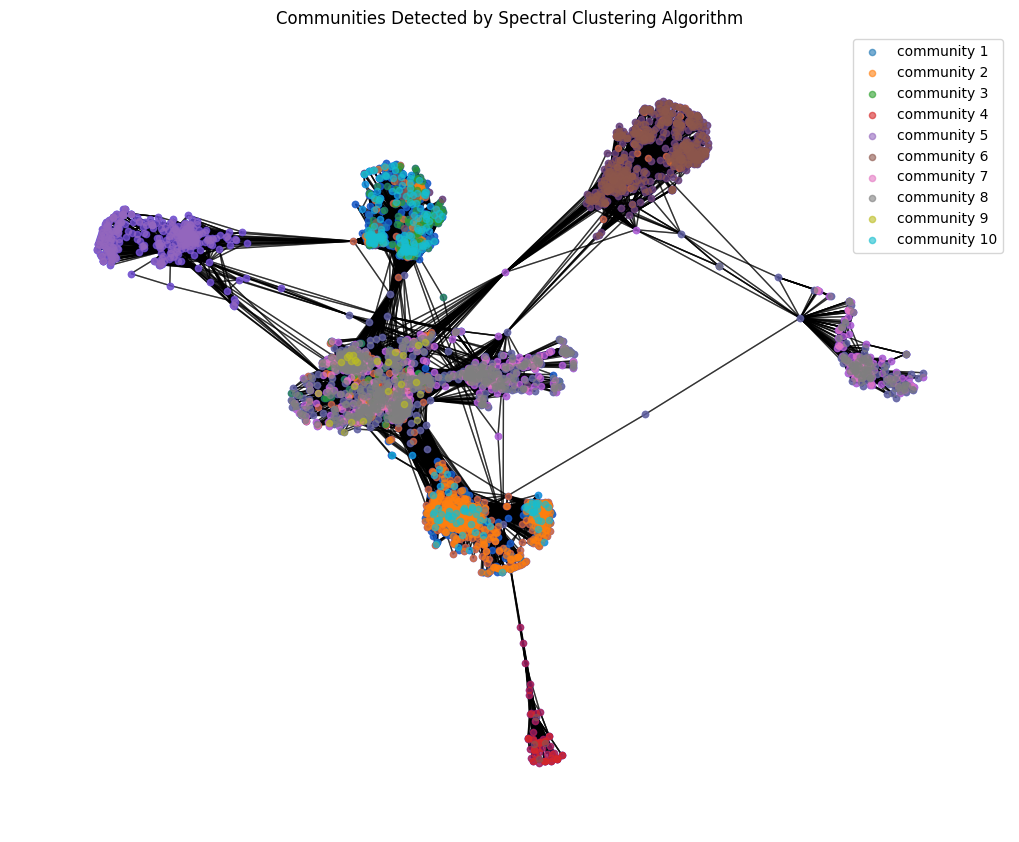

In [45]:
# Plot nodes without community information
plt.figure(figsize=(10, 8))
nx.draw(graph, pos, node_size=20, node_color="blue", alpha=0.6, with_labels=False)
plt.title("Communities Detected by Spectral Clustering Algorithm")

# Plot nodes with community information
for i, community in enumerate(spectral_communities):
  nx.draw_networkx_nodes(graph, pos, nodelist=community, node_color=plt.cm.tab10(i), node_size=20, alpha=0.6, label=f"community {i+1}")
nx.draw_networkx_edges(graph, pos, alpha=0.5)
plt.legend()
plt.show()

## 8.1) Metrics for Spectral Clustering Algorithm

In [46]:
spectral_modularity_score = nx.algorithms.community.modularity(graph, spectral_communities)

In [47]:
# Calculate normalized cut ratio
cut_ratios = []
for community in spectral_communities:
    cut_size = nx.cut_size(graph, community)
    normalized_cut = cut_size / len(community)
    cut_ratios.append(normalized_cut)
spectral_normalized_cut_ratio = np.mean(cut_ratios)

In [48]:
cluster_labels = np.zeros(graph.number_of_nodes())
for i, community in enumerate(spectral_communities):
    cluster_labels[community] = i
spectral_silhouette = silhouette_score(nx.adjacency_matrix(graph).todense(), cluster_labels, metric='euclidean')

In [49]:
spectral_compactness = total_compactness(spectral_communities, graph)
spectral_chbscore = calinski_harabasz_score(nx.adjacency_matrix(graph).todense(), cluster_labels)

In [50]:
spectral_separability = calculate_separability(spectral_communities, graph)

In [51]:
print(f"Spectral Modularity: {spectral_modularity_score}")
print(f"Spectral Normalized Cut Ratio: {spectral_normalized_cut_ratio}")
print(f"Spectral Silhouette Score: {spectral_silhouette}")
print(f"Spectral Total Compactness: {spectral_compactness}")
print(f"Spectral Calinski Harabasz Score: {spectral_chbscore}")
print(f"Spectral Separability: {spectral_separability}")

Spectral Modularity: 0.2567716239221784
Spectral Normalized Cut Ratio: 29.99816549318039
Spectral Silhouette Score: -0.18616412114542585
Spectral Total Compactness: 1.675269365186131
Spectral Calinski Harabasz Score: 79.95491799265794
Spectral Separability: 15.077424286675184


# 9) Labelled Propagation Algorithm for Community Detection

In [52]:
label_propagation_communities = nx.algorithms.community.label_propagation_communities(graph)
print(len(label_propagation_communities))
print("Detected Communities using Label Propagation Algorithm:")
for i, community in enumerate(label_propagation_communities):
    if len(community) >= 10:
        print(f"Community {i + 1}: {list(community)}")

44
Detected Communities using Label Propagation Algorithm:
Community 1: [0, 1, 3, 5, 7, 9, 10, 11, 12, 13, 15, 16, 18, 21, 22, 23, 25, 26, 27, 29, 30, 31, 37, 38, 39, 40, 43, 45, 47, 48, 50, 51, 54, 55, 56, 59, 60, 61, 62, 63, 65, 66, 67, 69, 72, 73, 74, 75, 76, 77, 79, 81, 82, 83, 84, 85, 87, 88, 96, 98, 103, 104, 105, 106, 109, 113, 114, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 128, 129, 130, 132, 133, 134, 141, 142, 146, 148, 153, 155, 156, 157, 158, 160, 161, 164, 165, 166, 168, 169, 170, 172, 176, 178, 183, 185, 186, 188, 190, 191, 199, 200, 202, 203, 206, 207, 208, 209, 210, 211, 212, 213, 215, 221, 222, 223, 224, 228, 229, 231, 232, 234, 235, 236, 237, 238, 239, 240, 246, 247, 248, 250, 252, 257, 258, 260, 261, 265, 267, 268, 269, 270, 271, 272, 274, 276, 277, 280, 283, 285, 286, 287, 288, 290, 291, 292, 294, 295, 297, 298, 301, 303, 304, 308, 311, 313, 314, 315, 316, 317, 318, 322, 323, 324, 325, 329, 331, 332, 334, 335, 336, 338, 339, 340, 341, 342, 344, 345, 347]
Com

/usr/local/lib/python3.11/dist-packages/networkx/drawing/nx_pylab.py:457: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


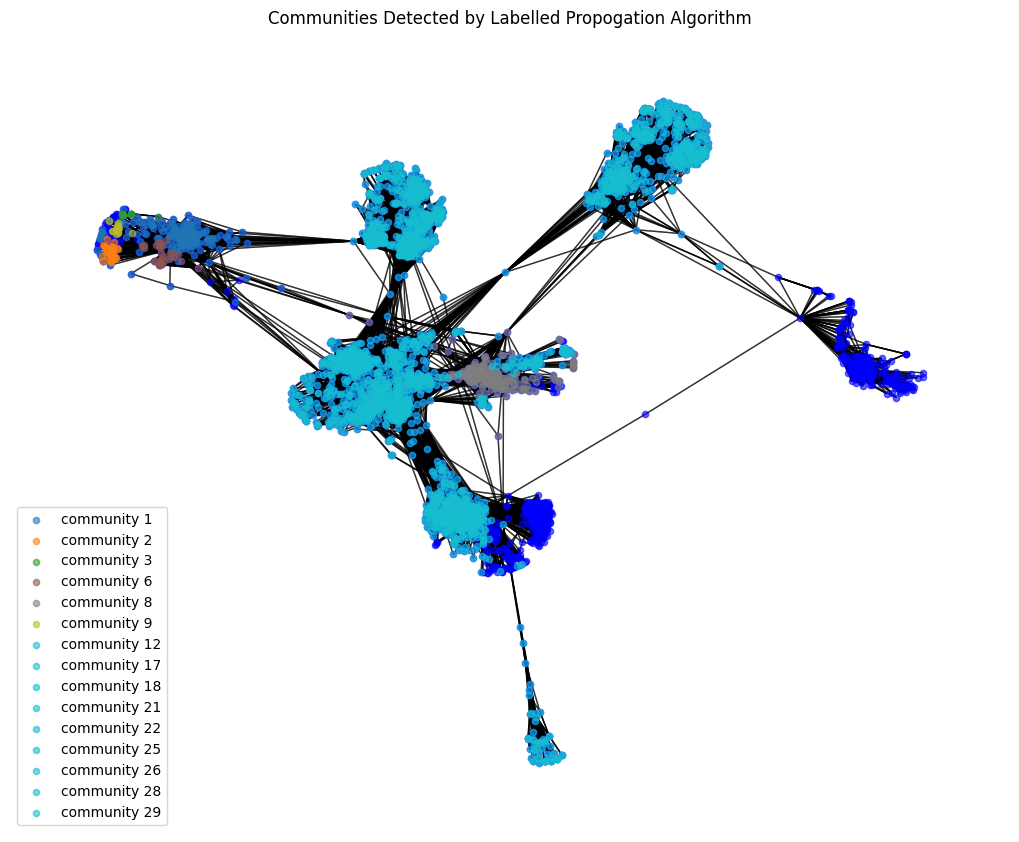

In [53]:
# Plot nodes without community information
plt.figure(figsize=(10, 8))
nx.draw(graph, pos, node_size=20, node_color="blue", alpha=0.6, with_labels=False)
plt.title("Communities Detected by Labelled Propogation Algorithm")

# Plot nodes with community information for the first 15 communities with more than 10 nodes
count = 0
for i, community in enumerate(label_propagation_communities):
    if len(community) >= 10:
        nx.draw_networkx_nodes(graph, pos, nodelist=community, node_color=plt.cm.tab10(i), node_size=20, alpha=0.6, label=f"community {i+1}")
        count += 1
    if count >= 15:
        break

nx.draw_networkx_edges(graph, pos, alpha=0.5)
plt.legend()
plt.show()

## 9.1) Metrics for Labelled Propagation Algorithm

In [54]:
lpa_modularity_score = nx.algorithms.community.modularity(graph, label_propagation_communities)

In [55]:
cut_ratios = []
for community in label_propagation_communities:
    cut_size = nx.cut_size(graph, community)
    normalized_cut = cut_size / len(community)
    cut_ratios.append(normalized_cut)
lpa_normalized_cut_ratio = np.mean(cut_ratios)

In [56]:
label_propagation_communities = [list(community) for community in label_propagation_communities]

In [57]:
cluster_labels = np.zeros(graph.number_of_nodes())
for i, community in enumerate(label_propagation_communities):
    cluster_labels[community] = i
lpa_silhouette = silhouette_score(nx.adjacency_matrix(graph).todense(), cluster_labels, metric='euclidean')

In [58]:
lpa_compactness = total_compactness(label_propagation_communities, graph)
lpa_chbscore = calinski_harabasz_score(nx.adjacency_matrix(graph).todense(), cluster_labels)

In [59]:
lpa_separability = calculate_separability(label_propagation_communities, graph)

In [60]:
print(f"LPA Modularity: {lpa_modularity_score}")
print(f"LPA Normalized Cut Ratio: {lpa_normalized_cut_ratio}")
print(f"LPA Silhouette Score: {lpa_silhouette}")
print(f"LPA Compactness: {lpa_compactness}")
print(f"LPA Calinski Harabasz Score: {lpa_chbscore}")
print(f"LPA Separability: {lpa_separability}")

LPA Modularity: 0.7368407345348218
LPA Normalized Cut Ratio: 1.7332541547012335
LPA Silhouette Score: -0.3157669348819561
LPA Compactness: 9.012389493950169
LPA Calinski Harabasz Score: 7.407200997869708
LPA Separability: 387.5327482398569


# 10) Infomap Algorithm for Community Detection

In [61]:
!pip install cdlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.6/263.6 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 98.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 96.8 MB/s eta 0:00:00


In [62]:
from cdlib import algorithms

# Execute the Infomap algorithm
infomap_communities = algorithms.infomap(graph)
print(len(infomap_communities.communities))

# Print the detected communities, limited to 15 communities
print("Detected Communities using Infomap Algorithm:")
for i, community in enumerate(infomap_communities.communities):
    if len(community) >= 10:
        print(f"Community {i + 1}: {community}")

Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'bayanpy', 'graph_tool', 'leidenalg'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'pyclustering', 'ASLPAw'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'leidenalg'}
94
Detected Communities using Infomap Algorithm:
Community 1: [1976, 536, 3125, 3126, 3129, 3131, 3132, 3137, 3139, 3140, 3147, 3149, 3151, 3152, 3155, 3157, 3161, 3163, 3169, 3170, 3171, 3177, 3180, 3181, 3183, 3184, 3185, 3187, 3188, 3189, 3191, 3192, 3193, 3195, 3196, 3197, 3200, 3202, 3204, 3208, 3209, 3210, 3211, 3212, 3214, 3217, 3219, 3223, 3224, 3227, 3228, 3229, 3235, 3239, 3242, 3246, 3249, 3250, 3251, 3254, 3257, 3259, 3260, 3261, 3264, 3266, 3267, 3269, 3272, 3273, 3275, 3277, 3279, 3280, 3284, 3285, 3286, 3287, 3297, 3298, 3299, 3302, 3305, 3306, 3307, 3310, 3312, 3315, 3316, 3317, 3318, 3320, 3321, 3324, 33

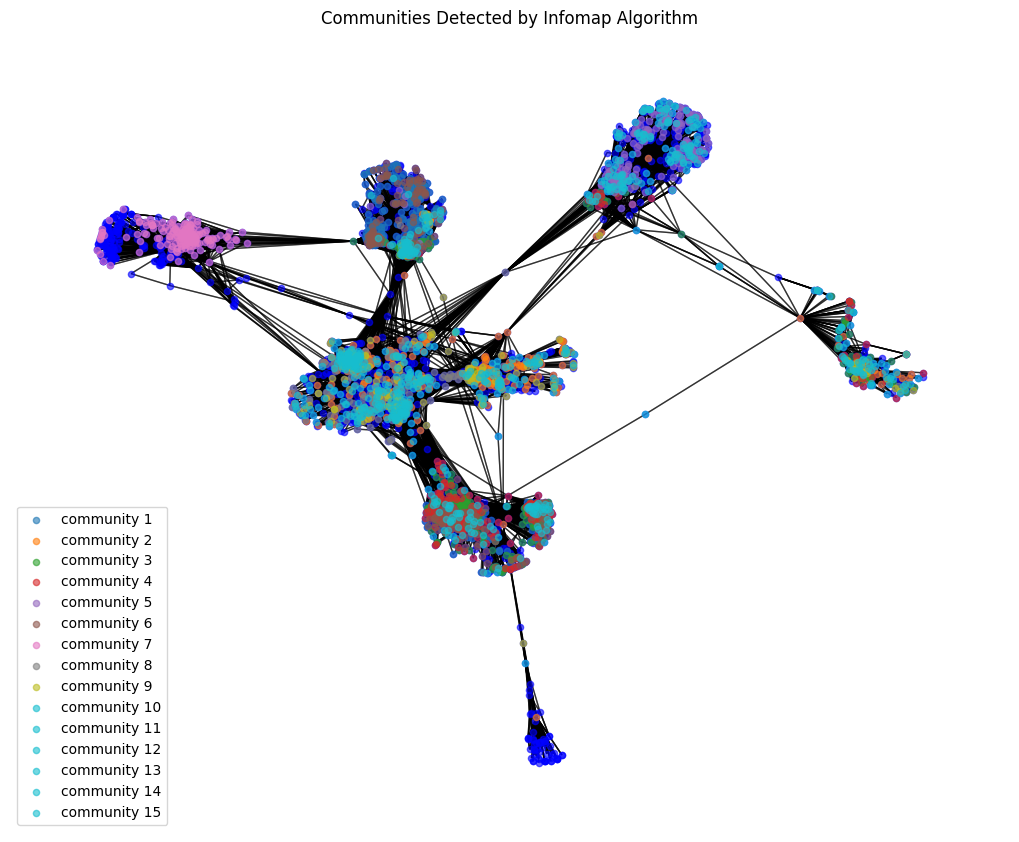

In [63]:
# Plot nodes without community information
plt.figure(figsize=(10, 8))
nx.draw(graph, pos, node_size=20, node_color="blue", alpha=0.6, with_labels=False)
plt.title("Communities Detected by Infomap Algorithm")

# Plot nodes with community information for the first 15 communities with more than 10 nodes
count = 0
for i, community in enumerate(infomap_communities.communities):
    if len(community) >= 10:
        nx.draw_networkx_nodes(graph, pos, nodelist=community, node_color=plt.cm.tab10(i), node_size=20, alpha=0.6, label=f"community {i+1}")
        count += 1
    if count >= 15:
        break

nx.draw_networkx_edges(graph, pos, alpha=0.5)
plt.legend()
plt.show()

## 10.1) Metrics for Infomap Algorithm

In [64]:
infomap_communities = [list(community) for community in infomap_communities.communities]

In [65]:
infomap_modularity_score = nx.algorithms.community.modularity(graph, infomap_communities)

In [66]:
cut_ratios = []
for community in infomap_communities:
    cut_size = nx.cut_size(graph, community)
    normalized_cut = cut_size / len(community)
    cut_ratios.append(normalized_cut)
infomap_normalized_cut_ratio = np.mean(cut_ratios)

In [67]:
cluster_labels = np.zeros(graph.number_of_nodes())
for i, community in enumerate(infomap_communities):
    cluster_labels[community] = i
adj_matrix_array = np.asarray(nx.adjacency_matrix(graph).todense())
infomap_silhouette = silhouette_score(adj_matrix_array, cluster_labels, metric='euclidean')

In [68]:
infomap_compactness = total_compactness(infomap_communities, graph)
infomap_chbscore = calinski_harabasz_score(np.asarray(nx.adjacency_matrix(graph).todense()), cluster_labels)

In [69]:
infomap_separability = calculate_separability(infomap_communities, graph)

In [70]:
print(f"Infomap Modularity: {infomap_modularity_score}")
print(f"Infomap Normalized Cut Ratio: {infomap_normalized_cut_ratio}")
print(f"Infomap Silhouette Score: {infomap_silhouette}")
print(f"Infomap Compactness: {infomap_compactness}")
print(f"Infomap Calinski Harabasz Score: {infomap_chbscore}")
print(f"Infomap Separability: {infomap_separability}")

Infomap Modularity: 0.12890551683165363
Infomap Normalized Cut Ratio: 36.98035278723301
Infomap Silhouette Score: -0.309981917318524
Infomap Compactness: 9.51941465383819
Infomap Calinski Harabasz Score: 2.885493592568522
Infomap Separability: 885.3055628069599


# 11) Leading Eigen Vector Method for Community Detection

In [71]:
from cdlib import algorithms

# Execute the Infomap algorithm
eigenvector_communities = algorithms.eigenvector(graph)
print(len(eigenvector_communities.communities))

# Print the detected communities
print("Detected Communities using EigenVector Algorithm:")
for i, community in enumerate(eigenvector_communities.communities[:15]):
    if len(community) >= 10:
        print(f"Community {i + 1}: {community}")

18
Detected Communities using EigenVector Algorithm:
Community 1: [107, 998, 1040, 1163, 1411, 1413, 1418, 1420, 1421, 1423, 1424, 1425, 1426, 1427, 1428, 1430, 1432, 1434, 1435, 1436, 1437, 1439, 1440, 1441, 1442, 1443, 1446, 1448, 1449, 1451, 1459, 1460, 1461, 1464, 1465, 1466, 1467, 1469, 1470, 1473, 1474, 1475, 1480, 1481, 1482, 1486, 1487, 1492, 1493, 1494, 1496, 1497, 1499, 1501, 1505, 1507, 1508, 1509, 1510, 1511, 1512, 1513, 1515, 1516, 1517, 1518, 1520, 1522, 1526, 1530, 1531, 1536, 1537, 1538, 1539, 1540, 1541, 1542, 1543, 1544, 1545, 1548, 1552, 1553, 1554, 1557, 1559, 1560, 1561, 1562, 1563, 1564, 1567, 1568, 1569, 1570, 1571, 1572, 1573, 1575, 1576, 1577, 1579, 1582, 1583, 1585, 1587, 1588, 1589, 1590, 1592, 1593, 1597, 1598, 1600, 1601, 1602, 1605, 1606, 1607, 1608, 1609, 1610, 1615, 1617, 1619, 1621, 1624, 1625, 1626, 1630, 1631, 1633, 1637, 1638, 1639, 1640, 1642, 1644, 1646, 1647, 1649, 1652, 1654, 1657, 1659, 1660, 1661, 1663, 1664, 1665, 1666, 1667, 1668, 1669, 1670,

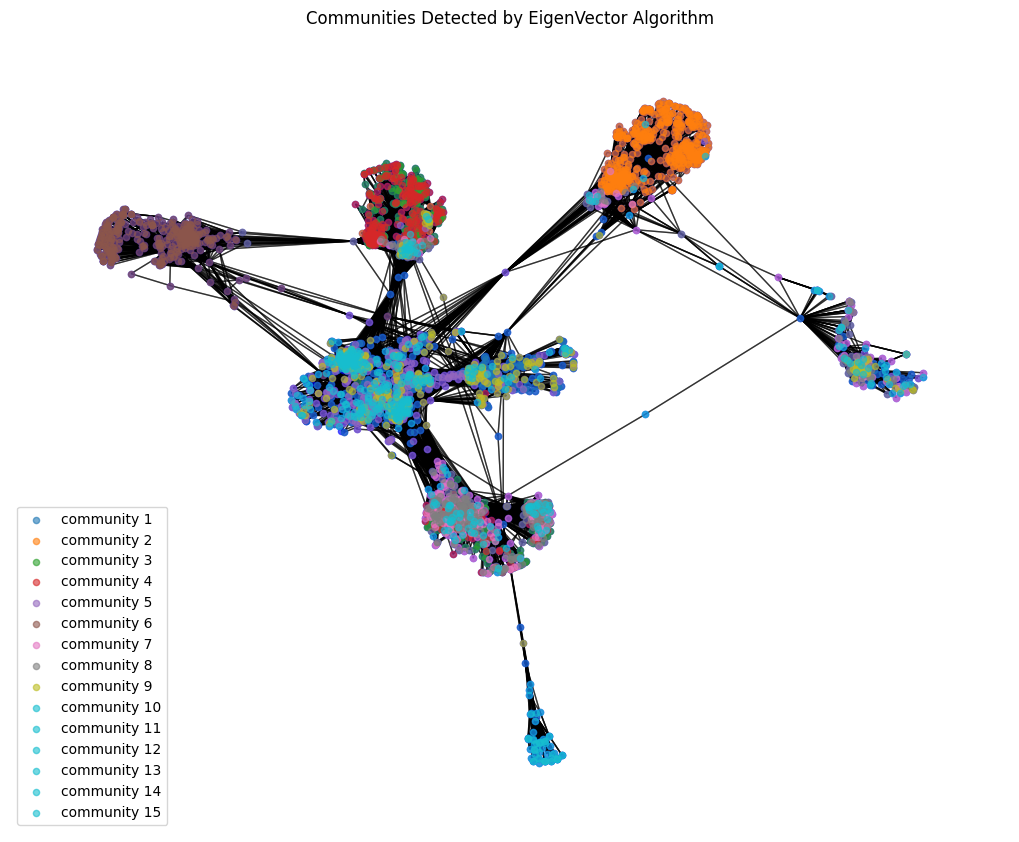

In [72]:
# Plot nodes without community information
plt.figure(figsize=(10, 8))
nx.draw(graph, pos, node_size=20, node_color="blue", alpha=0.6, with_labels=False)
plt.title("Communities Detected by EigenVector Algorithm")

# Plot nodes with community information for the first 15 communities with more than 10 nodes
count = 0
for i, community in enumerate(eigenvector_communities.communities):
    if len(community) >= 10:
        nx.draw_networkx_nodes(graph, pos, nodelist=community, node_color=plt.cm.tab10(i), node_size=20, alpha=0.6, label=f"community {i+1}")
        count += 1
    if count >= 15:
        break

nx.draw_networkx_edges(graph, pos, alpha=0.5)
plt.legend()
plt.show()

## 11.1) Metrics for Eigen Vector Method

In [73]:
evec_communities = [list(community) for community in eigenvector_communities.communities]

In [74]:
evec_modularity_score = nx.algorithms.community.modularity(graph, evec_communities)

In [75]:
cut_ratios = []
for community in evec_communities:
    cut_size = nx.cut_size(graph, community)
    normalized_cut = cut_size / len(community)
    cut_ratios.append(normalized_cut)
evec_normalized_cut_ratio = np.mean(cut_ratios)

In [76]:
cluster_labels = np.zeros(graph.number_of_nodes())
for i, community in enumerate(evec_communities):
    cluster_labels[community] = i
adj_matrix_array = np.asarray(nx.adjacency_matrix(graph).todense())
evec_silhouette = silhouette_score(adj_matrix_array, cluster_labels, metric='euclidean')

In [77]:
evec_compactness = total_compactness(evec_communities, graph)
evec_chbscore = calinski_harabasz_score(np.asarray(nx.adjacency_matrix(graph).todense()), cluster_labels)

In [78]:
evec_separability = calculate_separability(evec_communities, graph)

In [79]:
print(f"EVec Modularity: {evec_modularity_score}")
print(f"EVec Normalized Cut Ratio: {evec_normalized_cut_ratio}")
print(f"EVec Silhouette Score: {evec_silhouette}")
print(f"EVec Compactness: {evec_compactness}")
print(f"EVec Calinski Harabasz Score: {evec_chbscore}")
print(f"EVec Separability: {evec_separability}")

EVec Modularity: 0.2094247228119307
EVec Normalized Cut Ratio: 31.615234910059414
EVec Silhouette Score: -0.2542860576234448
EVec Compactness: 0.5322625343224353
EVec Calinski Harabasz Score: 10.358417036967696
EVec Separability: 9.048463083481396


# 12) Final Metric Outputs

K Means Modularity: 0.03750166342361561 <br>
K Means Normalized Cut Ratio: 45.83736425370892 <br>
K Means Silhouette Score: 0.15082033786927426 <br>
K Means Compactness: 6.037961348228847 <br>
K Means Calinski Harabasz Score : 183.3559476229275 <br>
K Means Separability: 8.988519342290834 <br><br>

Louvain Modularity: 0.7773775199040279 <br>
Louvain Normalized Cut Ratio: 1.7549852359383116 <br>
Louvain Silhouette Score: -0.2501875285464944 <br>
Louvain Compactness: 0.45634880916931125 <br>
Louvain Calinski Harabasz Score: 16.371967129485043 <br>
Louvain Separability: 5.476185710031737 <br><br>

Spectral Modularity: 0.25677162392217845 <br>
Spectral Normalized Cut Ratio: 29.998165493180387 <br>
Spectral Silhouette Score: -0.18616412114542585 <br>
Spectral Total Compactness: 1.6752693651861312 <br>
Spectral Calinski Harabasz Score: 79.95491799265797 <br>
Spectral Separability: 15.07742428667518 <br><br>

LPA Modularity: 0.7368407345348218 <br>
LPA Normalized Cut Ratio: 1.7332541547012335 <br>
LPA Silhouette Score: -0.3157669348819561 <br>
LPA Compactness: 9.012389493950169 <br>
LPA Calinski Harabasz Score: 7.407200997869708 <br>
LPA Separability: 387.5327482398569 <br><br>

Infomap Modularity: 0.12993544825075373 <br>
Infomap Normalized Cut Ratio: 36.71226095368189 <br>
Infomap Silhouette Score: -0.31010422809463073 <br>
Infomap Compactness: 9.504474364263057 <br>
Infomap Calinski Harabasz Score: 2.9424060973375847 <br>
Infomap Separability: 855.4026927836841 <br><br>

EVec Modularity: 0.2094247228119307 <br>
EVec Normalized Cut Ratio: 31.615234910059414 <br>
EVec Silhouette Score: -0.2542860576234448 <br>
EVec Compactness: 0.5322625343224353 <br>
EVec Calinski Harabasz Score: 10.358417036967696 <br>
EVec Separability: 9.048463083481396 <br>


# 13) Comparison of Metrics

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tabulate import tabulate

In [ ]:
algorithms = ['KMeans', 'Louvain', 'Spectral Clustering', 'Label Propagation', 'Infomap', 'Leading Eigenvector']
modularity_scores = [0.03750166342361561, 0.7773775199040279, 0.25677162392217845, 0.7368407345348218, 0.12993544825075373, 0.12993544825075373]
ncr_scores = [45.83736425370892, 1.7549852359383116, 29.998165493180387, 1.7332541547012335, 36.71226095368189, 31.615234910059414]
compactness_scores = [6.037961348228847, 0.45634880916931125, 1.6752693651861312, 9.012389493950169, 9.504474364263057, 0.5322625343224353]
chb_scores = [183.3559476229275, 16.371967129485043, 79.95491799265797, 7.407200997869708, 2.9424060973375847, 10.358417036967696]
separability_scores = [8.988519342290834, 5.476185710031737, 15.07742428667518, 387.5327482398569, 855.4026927836841, 9.048463083481396]
silhouette_scores = [0.15082033786927426, -0.2501875285464944, -0.18616412114542585, -0.3157669348819561, -0.31010422809463073, -0.2542860576234448]

In [ ]:
df = pd.DataFrame({
    'Algorithm': algorithms,
    'Modularity': modularity_scores,
    'Normalized Cut Ratio': ncr_scores,
    'Compactness': compactness_scores,
    'Calinski Harabasz Score': chb_scores,
    'Separability': separability_scores,
    'Silhouette Score': silhouette_scores
})

# Set Algorithm as index
df.set_index('Algorithm', inplace=True)

In [ ]:
print(tabulate(df, headers='keys', tablefmt='fancy_grid'))

╒═════════════════════╤══════════════╤════════════════════════╤═══════════════╤═══════════════════════════╤════════════════╤════════════════════╕
│ Algorithm           │   Modularity │   Normalized Cut Ratio │   Compactness │   Calinski Harabasz Score │   Separability │   Silhouette Score │
╞═════════════════════╪══════════════╪════════════════════════╪═══════════════╪═══════════════════════════╪════════════════╪════════════════════╡
│ KMeans              │    0.0375017 │               45.8374  │      6.03796  │                 183.356   │        8.98852 │           0.15082  │
├─────────────────────┼──────────────┼────────────────────────┼───────────────┼───────────────────────────┼────────────────┼────────────────────┤
│ Louvain             │    0.777378  │                1.75499 │      0.456349 │                  16.372   │        5.47619 │          -0.250188 │
├─────────────────────┼──────────────┼────────────────────────┼───────────────┼───────────────────────────┼────────────────┼

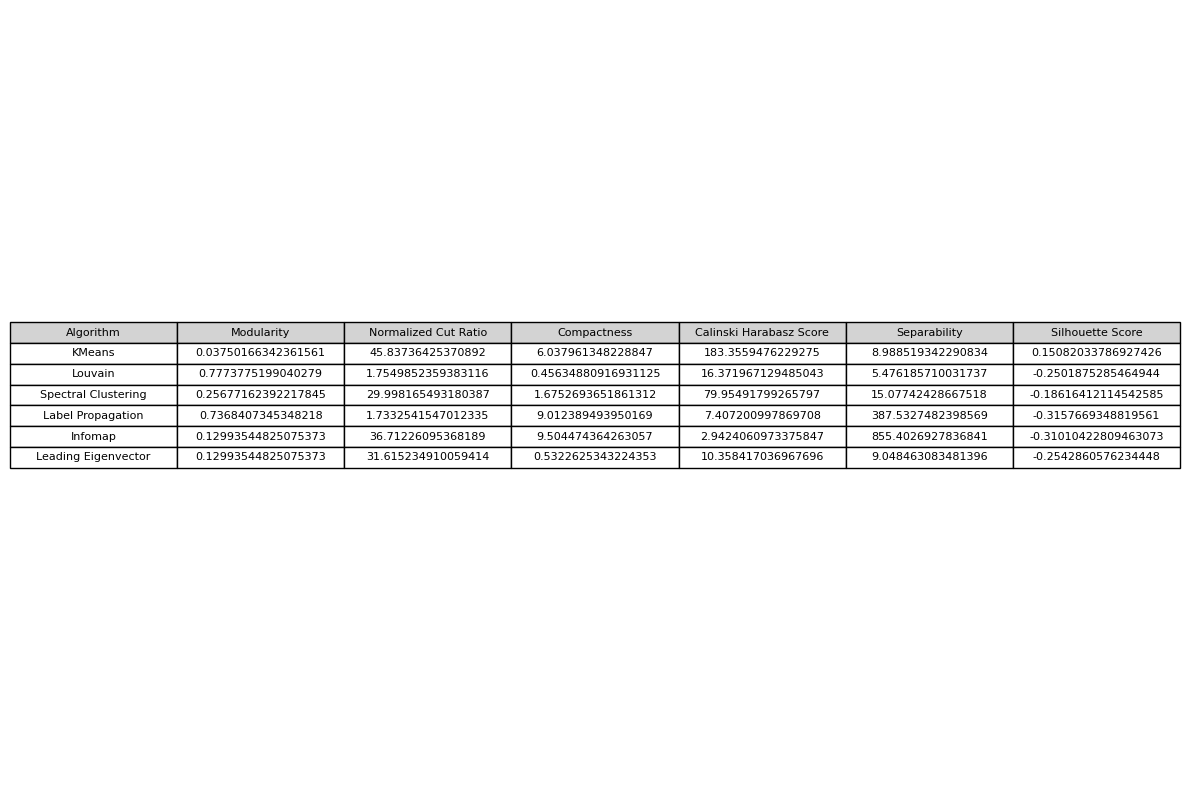

In [ ]:
df.reset_index(inplace=True)

# Plot table
plt.figure(figsize=(12, 8))
table = plt.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center', colColours=['lightgray']*len(df.columns))
table.auto_set_font_size(False)  # Turn off auto font size adjustment
table.set_fontsize(8)  # Set font size
plt.axis('off')  # Turn off axis
plt.tight_layout()

# Save as image
plt.savefig('table_image.png', dpi=300)
plt.show()

## 13.1) Modularity Score Comparison

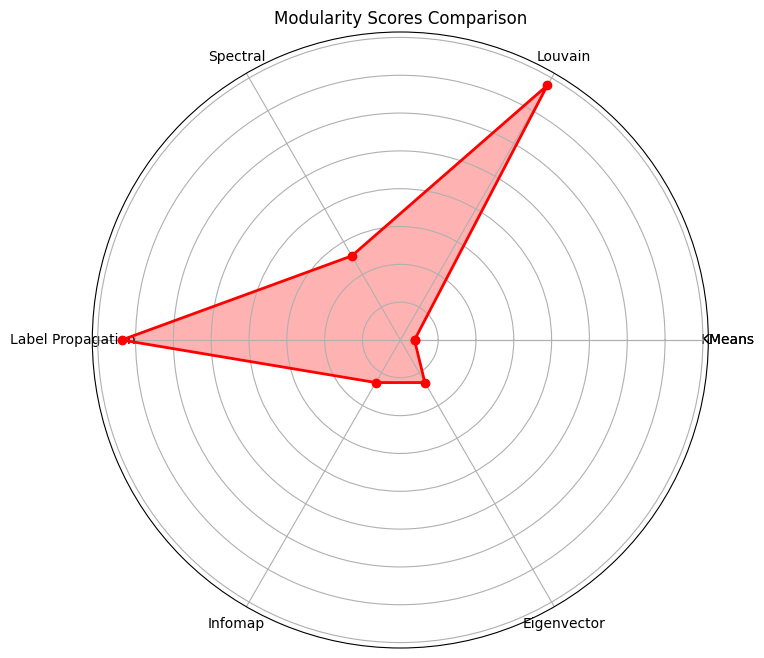

In [ ]:
algorithms = ['KMeans', 'Louvain', 'Spectral', 'Label Propagation', 'Infomap', 'Eigenvector']
modularity_scores = [0.03750166342361561, 0.7773775199040279, 0.25677162392217845, 0.7368407345348218, 0.12993544825075373, 0.12993544825075373]

# Number of algorithms
num_algorithms = len(algorithms)

# Compute angle for each axis
angles = np.linspace(0, 2 * np.pi, num_algorithms, endpoint=False).tolist()

# The plot is circular, so we need to "complete the loop"
modularity_scores += modularity_scores[:1]
angles += angles[:1]

# Plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

ax.plot(angles, modularity_scores, color='r', linewidth=2, linestyle='solid', marker='o')
ax.fill(angles, modularity_scores, color='r', alpha=0.3)

ax.set_yticklabels([])
ax.set_xticks(angles)
ax.set_xticklabels(algorithms + [algorithms[0]])  # Add the first algorithm label at the end to make the loop circular

plt.title('Modularity Scores Comparison')
plt.show()

## 13.2) Normalized Cut Ratio Comparison

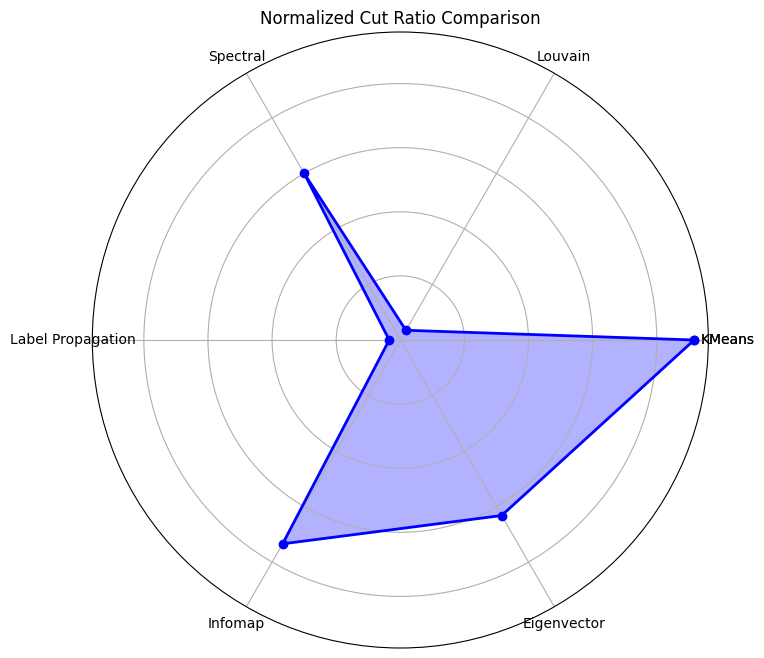

In [ ]:
algorithms = ['KMeans', 'Louvain', 'Spectral', 'Label Propagation', 'Infomap', 'Eigenvector']
ncr_scores = [45.83736425370892, 1.7549852359383116, 29.998165493180387, 1.7332541547012335, 36.71226095368189, 31.615234910059414]

# Number of algorithms
num_algorithms = len(algorithms)

# Compute angle for each axis
angles = np.linspace(0, 2 * np.pi, num_algorithms, endpoint=False).tolist()

# The plot is circular, so we need to "complete the loop"
ncr_scores += ncr_scores[:1]
angles += angles[:1]

# Plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

ax.plot(angles, ncr_scores, color='b', linewidth=2, linestyle='solid', marker='o')
ax.fill(angles, ncr_scores, color='b', alpha=0.3)

ax.set_yticklabels([])
ax.set_xticks(angles)
ax.set_xticklabels(algorithms + [algorithms[0]])  # Add the first algorithm label at the end to make the loop circular

plt.title('Normalized Cut Ratio Comparison')
plt.show()

## 13.3) Compactness Score Comparison

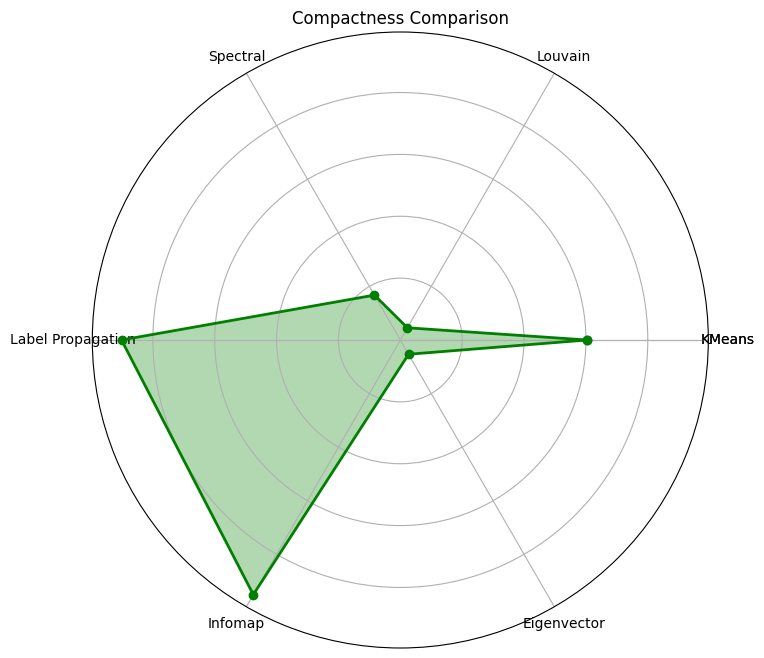

In [ ]:
algorithms = ['KMeans', 'Louvain', 'Spectral', 'Label Propagation', 'Infomap', 'Eigenvector']
compactness_scores = [6.037961348228847, 0.45634880916931125, 1.6752693651861312, 9.012389493950169, 9.504474364263057, 0.5322625343224353]

# Number of algorithms
num_algorithms = len(algorithms)

# Compute angle for each axis
angles = np.linspace(0, 2 * np.pi, num_algorithms, endpoint=False).tolist()

# The plot is circular, so we need to "complete the loop"
compactness_scores += compactness_scores[:1]
angles += angles[:1]

# Plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

ax.plot(angles, compactness_scores, color='g', linewidth=2, linestyle='solid', marker='o')
ax.fill(angles, compactness_scores, color='g', alpha=0.3)

ax.set_yticklabels([])
ax.set_xticks(angles)
ax.set_xticklabels(algorithms + [algorithms[0]])  # Add the first algorithm label at the end to make the loop circular

plt.title('Compactness Comparison')
plt.show()

## 13.4) Calinski Harabasz Score Comparison

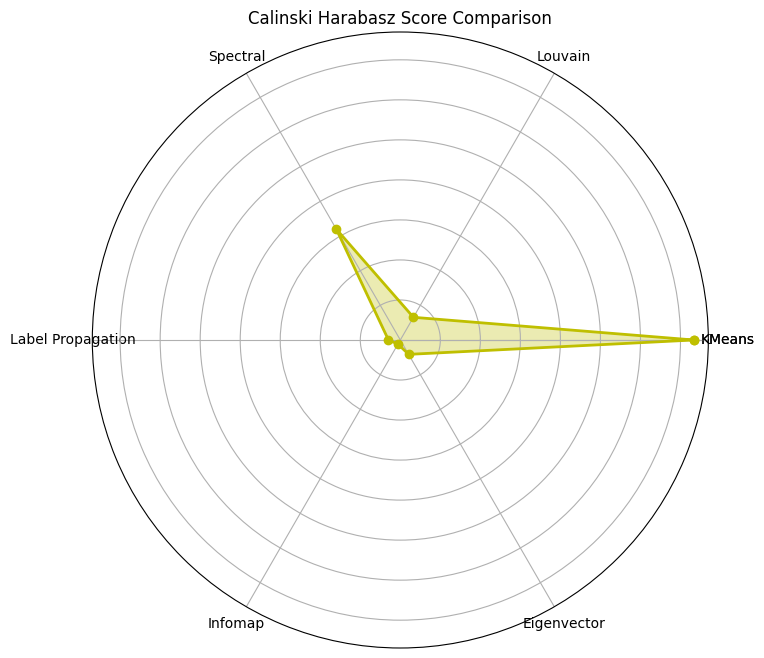

In [ ]:
algorithms = ['KMeans', 'Louvain', 'Spectral', 'Label Propagation', 'Infomap', 'Eigenvector']
chb_scores = [183.3559476229275, 16.371967129485043, 79.95491799265797, 7.407200997869708, 2.9424060973375847, 10.358417036967696]

# Number of algorithms
num_algorithms = len(algorithms)

# Compute angle for each axis
angles = np.linspace(0, 2 * np.pi, num_algorithms, endpoint=False).tolist()

# The plot is circular, so we need to "complete the loop"
chb_scores += chb_scores[:1]
angles += angles[:1]

# Plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

ax.plot(angles, chb_scores, color='y', linewidth=2, linestyle='solid', marker='o')
ax.fill(angles, chb_scores, color='y', alpha=0.3)

ax.set_yticklabels([])
ax.set_xticks(angles)
ax.set_xticklabels(algorithms + [algorithms[0]])  # Add the first algorithm label at the end to make the loop circular

plt.title('Calinski Harabasz Score Comparison')
plt.show()

## 13.5) Separability Comparison

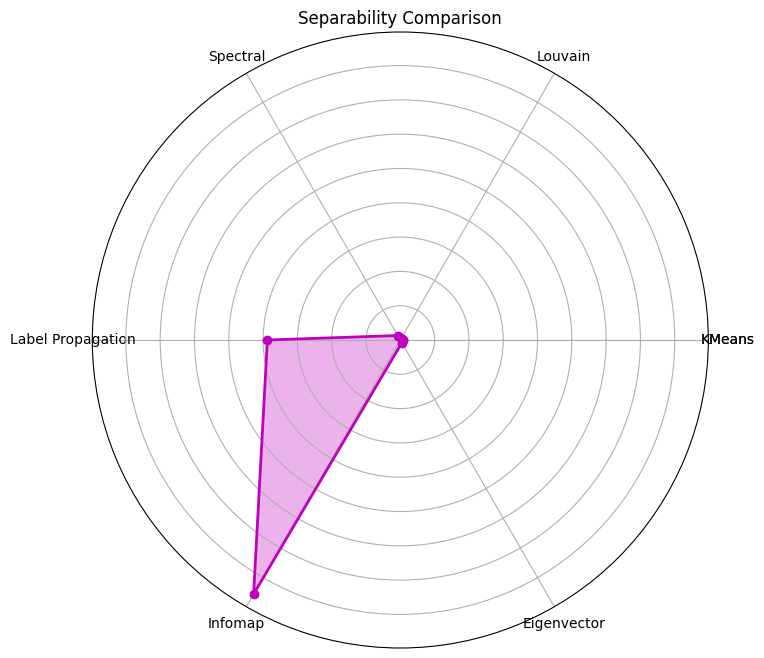

In [ ]:
algorithms = ['KMeans', 'Louvain', 'Spectral', 'Label Propagation', 'Infomap', 'Eigenvector']
separability_scores = [8.988519342290834, 5.476185710031737, 15.07742428667518, 387.5327482398569, 855.4026927836841, 9.048463083481396]

# Number of algorithms
num_algorithms = len(algorithms)

# Compute angle for each axis
angles = np.linspace(0, 2 * np.pi, num_algorithms, endpoint=False).tolist()

# The plot is circular, so we need to "complete the loop"
separability_scores += separability_scores[:1]
angles += angles[:1]

# Plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

ax.plot(angles, separability_scores, color='m', linewidth=2, linestyle='solid', marker='o')
ax.fill(angles, separability_scores, color='m', alpha=0.3)

ax.set_yticklabels([])
ax.set_xticks(angles)
ax.set_xticklabels(algorithms + [algorithms[0]])  # Add the first algorithm label at the end to make the loop circular

plt.title('Separability Comparison')
plt.show()

## 13.6) Silhouette Score Comparison

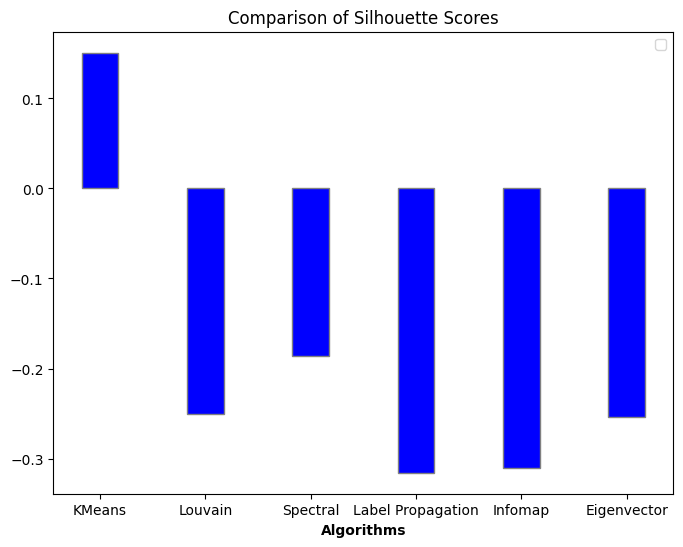

In [ ]:
algorithms = ['KMeans', 'Louvain', 'Spectral', 'Label Propagation', 'Infomap', 'Eigenvector']
silhouette_scores = [0.15082033786927426, -0.2501875285464944, -0.18616412114542585, -0.3157669348819561, -0.31010422809463073, -0.2542860576234448]

plt.figure(figsize=(8, 6))
# Set width of bar
bar_width = 0.35

# Set position of bar on X axis
r1 = np.arange(len(algorithms))

# Create bars
plt.bar(r1, silhouette_scores, color='b', width=bar_width, edgecolor='grey')

# Add xticks on the middle of the group bars
plt.xlabel('Algorithms', fontweight='bold')
plt.xticks([r for r in range(len(algorithms))], algorithms)

# Create legend & Show graphic
plt.legend()
plt.title('Comparison of Silhouette Scores')
plt.show()

# Extra - Analysis on a Specific Community

In [ ]:
community = [node for node in communities if 2 in node][0]

##  Diameter of Community

In [ ]:
diameter = nx.diameter(graph.subgraph(community))
print(f"Diameter of Community: {diameter}")

Diameter of Community: 5


##  Density of Community

In [ ]:
density = nx.density(graph.subgraph(community))
print(f"Density of Community: {density}")

Density of Community: 0.04244558444193258


##  Hub Nodes in the Community

In [ ]:
hub_nodes = sorted(community, key=lambda x: graph.degree()[x], reverse=True)[:5]
print("Top 5 Hub Nodes in Community:")
print(hub_nodes)

Top 5 Hub Nodes in Community:
[0, 136, 56, 67, 271]


##  Nodes with Highest Centrality in Community

In [ ]:
degree_centrality = nx.degree_centrality(graph.subgraph(community))
nodes_highest_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("Nodes with Highest Centrality in Community:")
print(nodes_highest_centrality)

Nodes with Highest Centrality in Community:
[(0, 0.9326145552560647), (56, 0.21024258760107817), (67, 0.20485175202156336), (271, 0.19676549865229112), (322, 0.1940700808625337)]


##  3D Visualization of Community

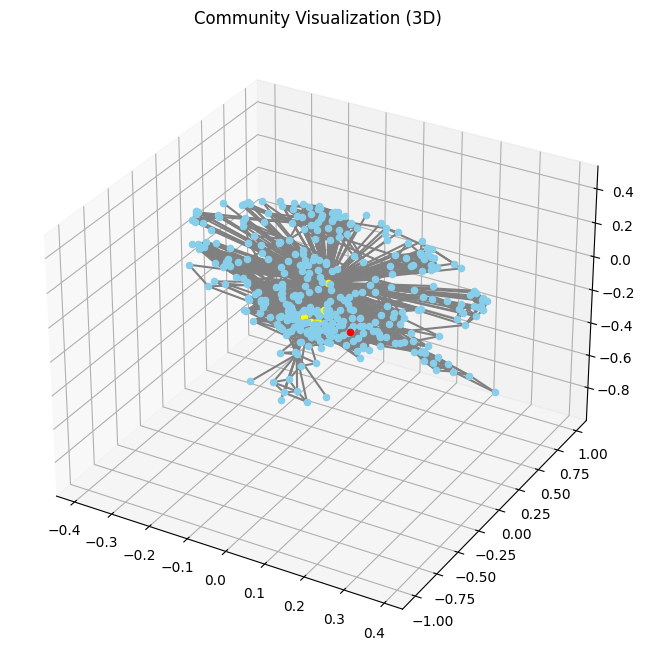

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Generate random z-coordinates for the nodes in Community 2
pos = nx.spring_layout(graph.subgraph(community), dim=3, seed=42)

# Draw nodes
for node in community:
    ax.scatter(pos[node][0], pos[node][1], pos[node][2], color='skyblue')

# Draw edges
for edge in graph.subgraph(community).edges():
    ax.plot([pos[edge[0]][0], pos[edge[1]][0]],
            [pos[edge[0]][1], pos[edge[1]][1]],
            [pos[edge[0]][2], pos[edge[1]][2]], color='gray')

# Highlight hub nodes in red
for node in hub_nodes:
    ax.scatter(pos[node][0], pos[node][1], pos[node][2], color='red')

# Highlight nodes with highest centrality in yellow
for node, centrality in nodes_highest_centrality:
    ax.scatter(pos[node][0], pos[node][1], pos[node][2], color='yellow')

ax.set_title('Community Visualization (3D)')
plt.show()

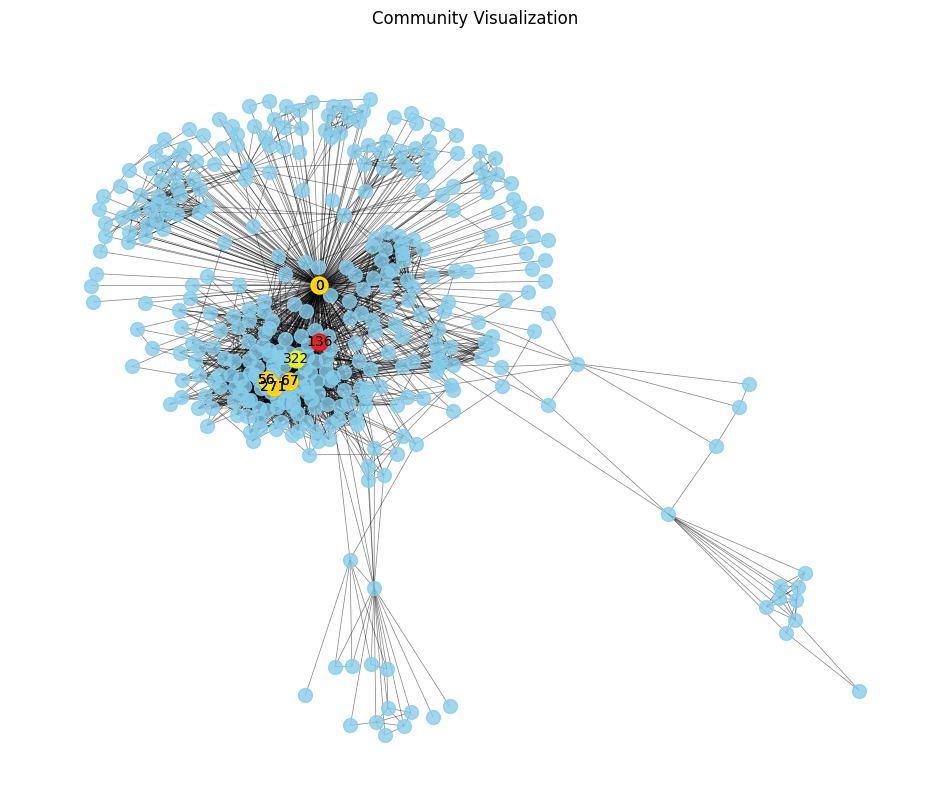

In [ ]:
plt.figure(figsize=(12, 10))

# Use Fruchterman-Reingold layout for better node spacing
pos = nx.spring_layout(graph.subgraph(community), seed=8)

# Draw nodes
nx.draw_networkx_nodes(graph.subgraph(community), pos, node_size=100, node_color='skyblue', alpha=0.8)

# Draw edges
nx.draw_networkx_edges(graph.subgraph(community), pos, width=0.5, alpha=0.5)

# Highlight hub nodes in red
hub_nodes = sorted(community, key=lambda x: graph.degree()[x], reverse=True)[:5]
nx.draw_networkx_nodes(graph.subgraph(hub_nodes), pos, node_size=150, node_color='red', alpha=0.8)

# Highlight nodes with highest centrality in yellow
degree_centrality = nx.degree_centrality(graph.subgraph(community))
nodes_highest_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
nx.draw_networkx_nodes(graph.subgraph([node for node, _ in nodes_highest_centrality]), pos,
                       node_size=150, node_color='yellow', alpha=0.8)

# Draw labels for hub nodes and nodes with highest centrality
hub_labels = {node: str(node) for node in hub_nodes}
nx.draw_networkx_labels(graph.subgraph(hub_nodes), pos, labels=hub_labels, font_size=10, font_color='black')

centrality_labels = {node: str(node) for node, _ in nodes_highest_centrality}
nx.draw_networkx_labels(graph.subgraph([node for node, _ in nodes_highest_centrality]), pos,
                        labels=centrality_labels, font_size=10, font_color='black')

plt.title('Community Visualization')
plt.axis('off')
plt.show()

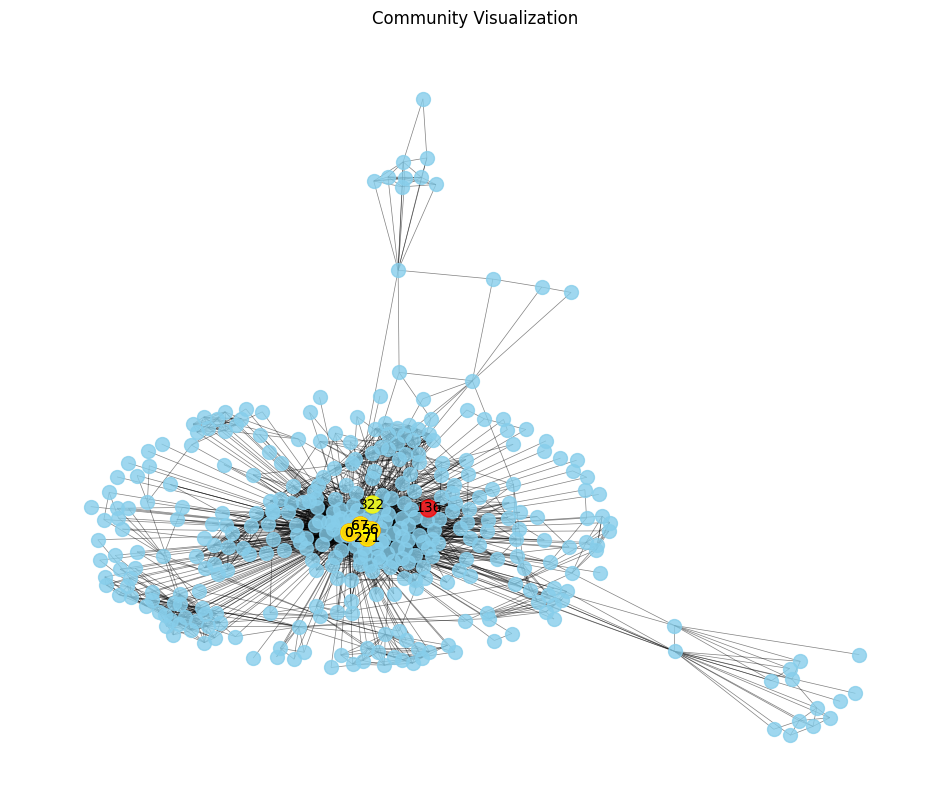

In [ ]:
plt.figure(figsize=(12, 10))

# Use Fruchterman-Reingold layout for better node spacing
pos = nx.spring_layout(graph.subgraph(community), seed=14)

# Draw nodes
nx.draw_networkx_nodes(graph.subgraph(community), pos, node_size=100, node_color='skyblue', alpha=0.8)

# Draw edges
nx.draw_networkx_edges(graph.subgraph(community), pos, width=0.5, alpha=0.5)

# Highlight hub nodes in red
hub_nodes = sorted(community, key=lambda x: graph.degree()[x], reverse=True)[:5]
nx.draw_networkx_nodes(graph.subgraph(hub_nodes), pos, node_size=150, node_color='red', alpha=0.8)

# Highlight nodes with highest centrality in yellow
degree_centrality = nx.degree_centrality(graph.subgraph(community))
nodes_highest_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
nx.draw_networkx_nodes(graph.subgraph([node for node, _ in nodes_highest_centrality]), pos,
                       node_size=150, node_color='yellow', alpha=0.8)

# Draw labels for hub nodes and nodes with highest centrality
hub_labels = {node: str(node) for node in hub_nodes}
nx.draw_networkx_labels(graph.subgraph(hub_nodes), pos, labels=hub_labels, font_size=10, font_color='black')

centrality_labels = {node: str(node) for node, _ in nodes_highest_centrality}
nx.draw_networkx_labels(graph.subgraph([node for node, _ in nodes_highest_centrality]), pos,
                        labels=centrality_labels, font_size=10, font_color='black')

plt.title('Community Visualization')
plt.axis('off')
plt.show()